In [1]:
import numpy as np 
import pandas as pd
import os
import scipy.stats as ss
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from scipy.stats import f_oneway
import pandas as pd
import datetime

In [2]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # 텐서플로가 첫 번째 GPU에 1GB 메모리만 할당하도록 제한
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
  except RuntimeError as e:
    # 프로그램 시작시에 가상 장치가 설정되어야만 합니다
    print(e)

# 원핫인코딩

### 데이터 전처리

In [3]:
# 데이터 불러오기
past_sales = pd.read_csv('C:/Users/PC/표/수요예측/rossmann-store-sales/train.csv')
store = pd.read_csv('C:/Users/PC/표/수요예측/rossmann-store-sales/store.csv')

# 데이터 제거
store = store.drop(['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'], axis=1)

# 데이터 정제 : 날짜
past_sales['Date'] = pd.to_datetime(past_sales['Date'], format="%Y-%m-%d")
past_sales['Month']=pd.DatetimeIndex(past_sales.Date).month
past_sales['Day']=pd.DatetimeIndex(past_sales.Date).day
past_sales = past_sales.drop(['Date'],axis=1)

# 데이터 정제 : StateHoliday
past_sales['StateHoliday'] = past_sales['StateHoliday'].replace({0:'d'}) # 0 값은 d로 대체
past_sales['StateHoliday'] = past_sales['StateHoliday'].replace({'0':'d'})# 0 값은 d로 대체

# 데이터 병합
data = pd.merge(left = past_sales,right = store, on = 'Store', how = 'right')

# 결측값 처리
data = data.dropna(axis=0)

# store 이름 제거
data = data.drop(['Store'],axis=1)

# 데이터 분리(수치형, 범주형)
digital_cols = ['Sales', 'Customers', 'CompetitionDistance', 'Month', 'Day']
digital_data = data[digital_cols]
digital_data = pd.DataFrame(digital_data.values, columns = digital_cols)

# 표준화
scaler = StandardScaler().fit(digital_data)
digital_data = pd.DataFrame(scaler.transform(digital_data),index = digital_data.index, columns = digital_cols)

categorey_clos = data.columns.drop(digital_cols)
categorey_data = data[categorey_clos]
categorey_data = pd.DataFrame(categorey_data.values, columns = categorey_clos)

# 인코딩
onehotencoding_cols = ['StateHoliday', 'StoreType', 'Assortment', 'DayOfWeek']
categorey_data = pd.get_dummies(data = categorey_data, columns = onehotencoding_cols)

# 데이터 병합
data = pd.concat([digital_data, categorey_data], axis = 1)

# 불필요한 데이터 제거
data = data.drop(['StateHoliday_d', 'StoreType_a', 'Assortment_a', 'DayOfWeek_4'],axis=1)


pd.options.display.max_columns = None

C:\Users\PC\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
target_col = 'Sales'
features_cols = data.columns.drop(target_col)        
features = data[features_cols]
target = data[target_col]
target = pd.DataFrame(target.values.reshape(-1,1))
features = features.values
target = target.values
# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.4, shuffle=False)
x_test,x_valid,y_test,y_valid = train_test_split(x_test, y_test, test_size=0.5, shuffle=False)

In [6]:
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)
x_valid = x_valid.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)
y_valid = y_valid.astype(np.float32)

In [7]:
print('train_data의 row : %s, column : %s'%(x_train.shape[0],x_train.shape[1]))
print('test_data의 row : %s, column : %s'%(x_test.shape[0],x_test.shape[1]))
print('val_data의 row : %s, column : %s'%(x_valid.shape[0],x_valid.shape[1]))

train_data의 row : 608740, column : 22
test_data의 row : 202913, column : 22
val_data의 row : 202914, column : 22


### 학습

In [8]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(256,input_dim = x_train.shape[1],activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(256,activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(256,activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(128,activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(1))

model.compile(optimizer='adam',
             loss='mean_squared_error',
             metrics=['mean_absolute_error'])

model_path = 'C:/project/rossmann-store-sales'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=model_path , monitor='val_mean_absolute_error', verbose=1, save_best_only=True)
# early_stopping = EarlyStopping(monitor='val_loss', patience=6)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               5888      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               6

In [9]:
start = datetime.datetime.now()

results= model.fit(x_train, y_train,
                    validation_data=(x_valid, y_valid),
                    batch_size=64,
                    epochs=50,
                   callbacks=[checkpoint])

end = datetime.datetime.now()
time = end-start
print("처리시간 : ", time)

Epoch 1/50
9509/9512 [============================>.] - ETA: 0s - loss: 0.1258 - mean_absolute_error: 0.2533
Epoch 00001: val_mean_absolute_error improved from inf to 0.20019, saving model to C:/project\rossmann-store-sales
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: C:/project\rossmann-store-sales\assets
9512/9512 [==============================] - 92s 10ms/step - loss: 0.1258 - mean_absolute_error: 0.2533 - val_loss: 0.1744 - val_mean_absolute_error: 0.2002
Epoch 2/50
9507/9512 [============================>.] - ETA: 0s - loss: 0.0892 - mean_absolute_error: 0.2205
Epoch 00002: val_mean_absolute_error did not improve from 0.20019
9512/9512 [==============================] - 81s 8ms/step - loss: 0.0892 - mean_absolute_error: 0.2205 - val_loss: 0.2613 - val_mean_abs

Epoch 48/50
9510/9512 [============================>.] - ETA: 0s - loss: 0.0699 - mean_absolute_error: 0.1974- ETA: 0s - loss: 0.0699 - mean_absol
Epoch 00048: val_mean_absolute_error did not improve from 0.20019
9512/9512 [==============================] - 92s 10ms/step - loss: 0.0699 - mean_absolute_error: 0.1974 - val_loss: 0.4019 - val_mean_absolute_error: 0.2194
Epoch 49/50
9510/9512 [============================>.] - ETA: 0s - loss: 0.0698 - mean_absolute_error: 0.1971- ET
Epoch 00049: val_mean_absolute_error did not improve from 0.20019
9512/9512 [==============================] - 98s 10ms/step - loss: 0.0698 - mean_absolute_error: 0.1971 - val_loss: 0.4102 - val_mean_absolute_error: 0.2176
Epoch 50/50
9511/9512 [============================>.] - ETA: 0s - loss: 0.0692 - mean_absolute_error: 0.1960
Epoch 00050: val_mean_absolute_error did not improve from 0.20019
9512/9512 [==============================] - 83s 9ms/step - loss: 0.0692 - mean_absolute_error: 0.1960 - val_loss: 0.

### 평가 : 테스트 데이터로

In [10]:
pred= model.predict(x_valid)

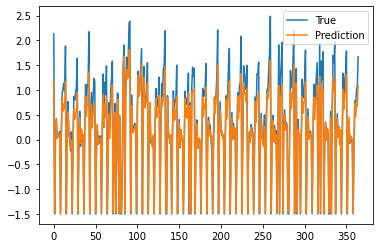

In [11]:
pred_365 = pred[0:365]
y_test_365 = y_valid[0:365]

fig = plt.figure(facecolor='white')
ax = fig.add_subplot(111)
ax.plot(y_test_365, label='True')
ax.plot(pred_365, label='Prediction')

ax.legend()
plt.show()

In [20]:
from sklearn.metrics import r2_score
r2 = r2_score(pred, y_valid)
print(r2)

0.6944433054539908


In [21]:
mse = mean_squared_error(pred, y_valid, squared=False)
print(mse)

0.64975804
